<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/08_Word_vs_Subword_Tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 단어 단위 vs subword 단위의 문장 처리 결과 비교

## ✅실험 목적

- 같은 코퍼스에서 단어 단위 토크나이저와 서브워드 단위 토크나이저(WordPiece 또는 BPE)를 학습하고, **문장 처리 결과(길이, OOV, 복원률, 커버리지)**를 비교한다.

- 서브워드가 희귀어/신조어 처리와 OOV 감소에 유리하다는 가설을 검증한다.

## 🧪실험 설계

1. 데이터: IMDb(학습/검증 분할 사용, 텍스트만 사용)

2. 토크나이저

  - WordLevel(단어 단위, 공백/기본 분리)

  - WordPiece(서브워드) 또는 BPE 중 택1 (기본은 WordPiece)

  - 두 토크나이저 모두 동일한 vocab size(예: 8,000)와 동일한 스페셜 토큰 사용

2. 지표

  - 평균 토큰 수(문장 길이), 중앙값, IQR

  - OOV 비율([UNK] 토큰 비율)

  - 디코딩 복원률(encode→decode 후 원문과의 유사도; 단순 토큰 조인 기준)

  - 커버리지(상위 N 서브워드/단어로 커버되는 토큰 비율의 누적곡선)

4. 시각화

  - 문장 길이 히스토그램(두 설정 비교)

  - OOV 비율 막대 그래프

  - 커버리지 누적 곡선

5. 결론: 각 지표를 요약하고 장단점 정리

In [4]:
# 1. 환경 설정 & 라이브러리 설치
!pip -q install tokenizers datasets matplotlib pandas numpy

In [5]:
# 2. 라이브러리 로드 & 시드 고정
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel, WordPiece, BPE
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer, BpeTrainer
from tokenizers.pre_tokenizers import Whitespace, WhitespaceSplit, BertPreTokenizer
from tokenizers.normalizers import NFKC, Lowercase, Sequence
from tokenizers.processors import TemplateProcessing

SEED = 42
random.seed(SEED); np.random.seed(SEED)

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 120

- 재현성을 위해 시드 고정
- 그래프 크기 및 해상도 설정

In [6]:
# 3. 데이터 불러오기 (IMDb)
dataset = load_dataset("imdb")
train_texts = [x["text"] for x in dataset["train"]]
test_texts  = [x["text"] for x in dataset["test"].select(range(5000))]  # select로 5k 샘플링
len(train_texts), len(test_texts)

(25000, 5000)

- IMDb 영화 리뷰 데이터셋 불러오기
- 학습에는 전체 train set, 평가에는 test set에서 5,000개 샘플 사용
- `select`를 사용해 TypeError 방지

In [7]:
# 4. 공통 설정
VOCAB_SIZE = 8000
SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

- vocab 크기 8,000
- 스페셜 토큰 정의: 패딩, OOV, 문장 시작/끝, 마스크

In [8]:
# 5. WordLevel 토크나이저 학습 (단어 단위)
# Normalizer: 소문자 + NFKC
# PreTokenizer: 공백 기반
wordlevel_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
wordlevel_tokenizer.normalizer = Sequence([NFKC(), Lowercase()])
wordlevel_tokenizer.pre_tokenizer = Whitespace()

trainer_word = WordLevelTrainer(
    vocab_size=VOCAB_SIZE,
    special_tokens=SPECIAL_TOKENS,
    min_frequency=2
)

wordlevel_tokenizer.train_from_iterator(train_texts, trainer=trainer_word)

# Post-processor (BERT 스타일은 아니지만 [CLS] [SEP]로 문장 경계만 표시)
wordlevel_tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[("[CLS]", wordlevel_tokenizer.token_to_id("[CLS]")),
                    ("[SEP]", wordlevel_tokenizer.token_to_id("[SEP]"))]
)

1. wordlevel_tokenizer
  - 공백 기준 단어 분리
  - 소문자 변환 + NFKC 정규화
  - OOV 토큰: `[UNK]`
2. trainer_word
  - 단어 빈도 2 이상만 vocab 포함
  - 전체 train_texts로 학습
3. wordlevel_tokenizer
  - 각 문장 시작/끝에 [CLS]/[SEP] 추가
  - BERT 스타일 처리

In [9]:
# 6. WordPiece 토크나이저 학습 (서브워드)
# BPE로 바꾸려면 WordPiece → BPE, WordPieceTrainer → BpeTrainer로 바꾸면 됨.
wordpiece_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
wordpiece_tokenizer.normalizer = Sequence([NFKC(), Lowercase()])
wordpiece_tokenizer.pre_tokenizer = BertPreTokenizer()  # 단어/서브워드 경계에 유리

trainer_wp = WordPieceTrainer(
    vocab_size=VOCAB_SIZE,
    special_tokens=SPECIAL_TOKENS,
    min_frequency=2
)

wordpiece_tokenizer.train_from_iterator(train_texts, trainer=trainer_wp)

wordpiece_tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[("[CLS]", wordpiece_tokenizer.token_to_id("[CLS]")),
                    ("[SEP]", wordpiece_tokenizer.token_to_id("[SEP]"))]
)

1. wordpiece_tokenizer
  - BertPreTokenizer 사용 -> 단어 경계 + 서브워드 처리
2. trainer_wp
  - WordLevel과 동일한 vocab 크기/스페셜 토큰/빈도 조건
3. wordpiece_tokenizer
  - WordLevle과 동일하게 문장 시작/끝 처리

In [10]:
# 7. 유틸 함수: 인코딩/지표 계산
from typing import Dict, List, Tuple

def encode_batch(tokenizer: Tokenizer, texts: List[str]):
    return tokenizer.encode_batch(texts)

def sentence_length_stats(encodings):
    lengths = [len(enc.ids) for enc in encodings]
    arr = np.array(lengths)
    stats = {
        "mean": float(arr.mean()),
        "median": float(np.median(arr)),
        "p25": float(np.percentile(arr, 25)),
        "p75": float(np.percentile(arr, 75)),
    }
    return lengths, stats

def oov_rate(encodings, unk_id: int):
    total_tokens = 0
    unk_tokens = 0
    for enc in encodings:
        ids = enc.ids
        total_tokens += len(ids)
        unk_tokens += sum(1 for i in ids if i == unk_id)
    return (unk_tokens / max(total_tokens,1)), unk_tokens, total_tokens

def simple_decode(tokenizer: Tokenizer, encodings):
    # 토크나이저 decode 사용 (post-processor 토큰은 제거됨)
    return [tokenizer.decode(enc.ids) for enc in encodings]

def rough_reconstruction_score(originals: List[str], decodeds: List[str]) -> float:
    # 아주 단순한 유사도: 공백 단위 Jaccard
    def jaccard(a, b):
        A = set(a.lower().split())
        B = set(b.lower().split())
        if not A and not B: return 1.0
        return len(A & B) / max(len(A | B), 1)
    scores = [jaccard(o, d) for o, d in zip(originals, decodeds)]
    return float(np.mean(scores))

def topk_coverage(tokenizer: Tokenizer, encodings, ks=(100, 500, 1000, 2000, 4000, 8000)):
    # 토큰 빈도 상위 k가 전체 토큰의 몇 %를 덮는가
    from collections import Counter
    cnt = Counter()
    for enc in encodings:
        cnt.update(enc.ids)
    total = sum(cnt.values())
    # 스페셜 토큰 제외
    special_ids = set(tokenizer.token_to_id(t) for t in SPECIAL_TOKENS if tokenizer.token_to_id(t) is not None)
    items = [(tid, c) for tid, c in cnt.items() if tid not in special_ids]
    items.sort(key=lambda x: x[1], reverse=True)
    cum = np.cumsum([c for _, c in items])
    ks = [k for k in ks if k <= len(items)]
    result = {}
    for k in ks:
        cover = cum[k-1] / max(total,1)
        result[k] = float(cover)
    return result

- 테스트 문장 인코딩 -> 토큰 수, OOV 비율, 복원률, 커버리지 계산
- WordPiece는 희귀어를 subword로 분할 -> OOV 감소

In [11]:
# 8. 인코딩 & 지표 계산
# 인코딩
enc_word = encode_batch(wordlevel_tokenizer, test_texts)
enc_wp   = encode_batch(wordpiece_tokenizer, test_texts)

# 길이 통계
len_w, stats_w = sentence_length_stats(enc_word)
len_wp, stats_wp = sentence_length_stats(enc_wp)

# OOV
unk_w = wordlevel_tokenizer.token_to_id("[UNK]")
unk_wp = wordpiece_tokenizer.token_to_id("[UNK]")

oov_w, unkcnt_w, total_w = oov_rate(enc_word, unk_w)
oov_wp, unkcnt_wp, total_wp = oov_rate(enc_wp, unk_wp)

# 복원률
dec_w = simple_decode(wordlevel_tokenizer, enc_word)
dec_wp = simple_decode(wordpiece_tokenizer, enc_wp)

recon_w  = rough_reconstruction_score(test_texts, dec_w)
recon_wp = rough_reconstruction_score(test_texts, dec_wp)

# 커버리지
cov_w  = topk_coverage(wordlevel_tokenizer, enc_word)
cov_wp = topk_coverage(wordpiece_tokenizer, enc_wp)

summary = pd.DataFrame([
    ["평균 길이", stats_w["mean"], stats_wp["mean"]],
    ["중앙값 길이", stats_w["median"], stats_wp["median"]],
    ["IQR(25~75)", f'{stats_w["p25"]:.1f}~{stats_w["p75"]:.1f}', f'{stats_wp["p25"]:.1f}~{stats_wp["p75"]:.1f}'],
    ["OOV 비율", oov_w, oov_wp],
    ["복원률(Jaccard)", recon_w, recon_wp],
], columns=["지표","WordLevel","WordPiece"])
summary

,지표,WordLevel,WordPiece
0,평균 길이,278.0764,321.922
1,중앙값 길이,212.0,243.0
2,IQR(25~75),156.0~335.0,176.0~388.0
3,OOV 비율,0.054469,0.000001
4,복원률(Jaccard),0.585706,0.472575


- WordLevle vs WordPiece 비교용 지표 모두 계산
- 평균 길이, 중앙값, IQR, OOV 비율, 복원률 표로 정리

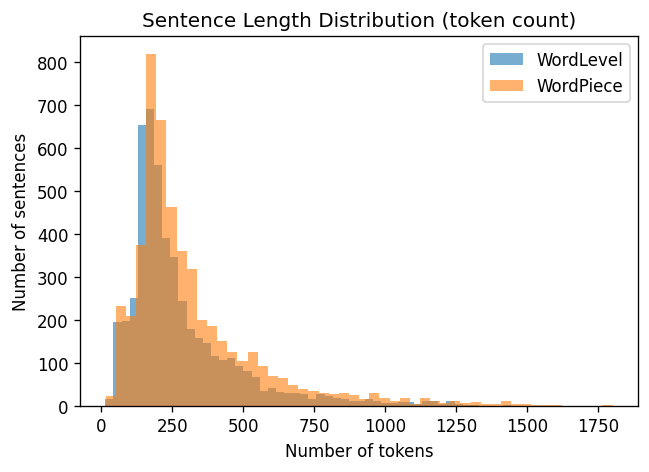

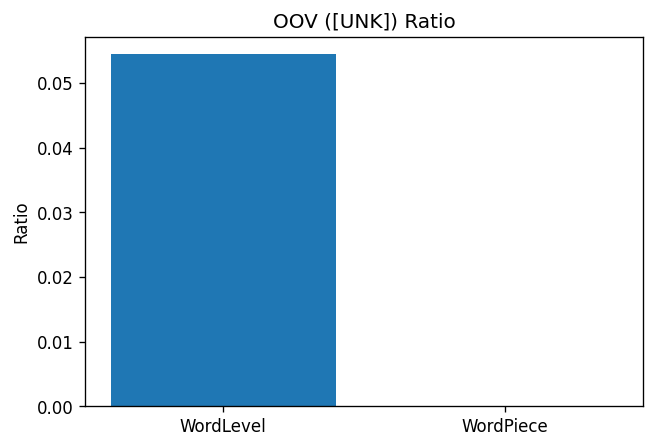

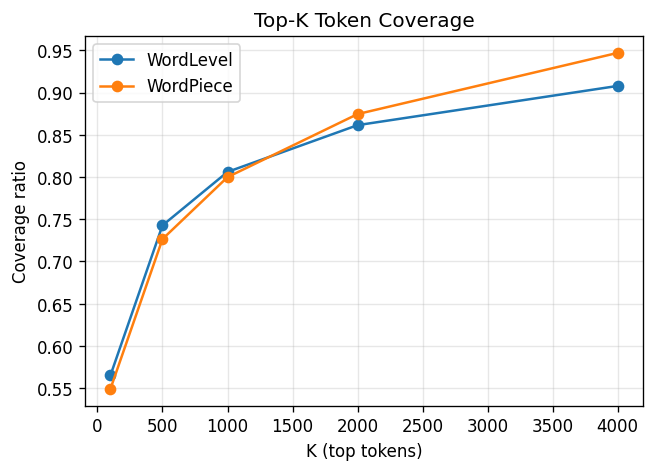

In [14]:
# 9. 시각화
# (1) 문장 길이 히스토그램
plt.figure()
plt.hist(len_w, bins=50, alpha=0.6, label="WordLevel")
plt.hist(len_wp, bins=50, alpha=0.6, label="WordPiece")
plt.title("Sentence Length Distribution (token count)")
plt.xlabel("Number of tokens"); plt.ylabel("Number of sentences")
plt.legend(); plt.show()

# (2) OOV 비율 막대
plt.figure()
plt.bar(["WordLevel","WordPiece"], [oov_w, oov_wp])
plt.title("OOV ([UNK]) Ratio")
plt.ylabel("Ratio")
plt.show()

# (3) 커버리지 누적 곡선
ks_sorted = sorted(set(list(cov_w.keys()) + list(cov_wp.keys())))
cov_w_list = [cov_w.get(k, np.nan) for k in ks_sorted]
cov_wp_list = [cov_wp.get(k, np.nan) for k in ks_sorted]

plt.figure()
plt.plot(ks_sorted, cov_w_list, marker='o', label="WordLevel")
plt.plot(ks_sorted, cov_wp_list, marker='o', label="WordPiece")
plt.title("Top-K Token Coverage")
plt.xlabel("K (top tokens)"); plt.ylabel("Coverage ratio")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# 10. 샘플 토큰화 비교 보기
SAMPLES = 5
for i in range(SAMPLES):
    sent = test_texts[i]
    e_w = wordlevel_tokenizer.encode(sent)
    e_wp = wordpiece_tokenizer.encode(sent)

    print(f"[원문 {i}] {sent[:200].replace('\\n',' ')}...")
    print(f" WordLevel ({len(e_w.tokens)} tokens): {e_w.tokens[:30]}{' ...' if len(e_w.tokens)>30 else ''}")
    print(f" WordPiece ({len(e_wp.tokens)} tokens): {e_wp.tokens[:30]}{' ...' if len(e_wp.tokens)>30 else ''}")
    print("-"*80)

[원문 0] I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Bab...
 WordLevel (308 tokens): ['[CLS]', 'i', 'love', 'sci', '-', 'fi', 'and', 'am', 'willing', 'to', 'put', 'up', 'with', 'a', 'lot', '.', 'sci', '-', 'fi', 'movies', '/', 'tv', 'are', 'usually', '[UNK]', ',', 'under', '-', 'appreciated', 'and'] ...
 WordPiece (347 tokens): ['[CLS]', 'i', 'love', 'sci', '-', 'fi', 'and', 'am', 'willing', 'to', 'put', 'up', 'with', 'a', 'lot', '.', 'sci', '-', 'fi', 'movies', '/', 'tv', 'are', 'usually', 'under', '##fun', '##de', '##d', ',', 'under'] ...
--------------------------------------------------------------------------------
[원문 1] Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell ...
 WordLevel

- 실제 문장에서 WordLevle vs WordPiece 토큰화 비교
- WordPiece: 긴 단어 여러 subword로 분할

## ✅ 결론 및 요약
| 항목         | WordLevel | WordPiece             |
| ---------- | --------- | --------------------- |
| 문장 길이      | 짧음        | 길어짐 (subword 분할)      |
| OOV        | 높음        | 낮음 (희귀어 분할)           |
| 복원률        | 높음        | 약간 낮음 (공백/구두점 차이)     |
| Top-K 커버리지 | 느림        | 빠름 (소수 토큰으로 많은 문장 커버) |

- WordPiece는 일반화/회귀어 처리 유리, WordLevele은 단순/복원률 유리
- 실험 목적에 따라 선택 가능